In [11]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import datetime
import os
import numpy as np
from timeit import default_timer
import ssl 
ssl._create_default_https_context = ssl._create_unverified_context
import syotil
from skimage import io
import glob
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import MSE
from tensorflow.python.data import Dataset
from tensorflow.keras.optimizers import SGD, Adam

from deepcell import losses
from deepcell import image_generators
from deepcell.utils import train_utils
from deepcell.utils import tracking_utils
from deepcell.utils.data_utils import get_data
from deepcell.utils.train_utils import rate_scheduler
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus
from deepcell.applications import NuclearSegmentation
from deepcell.applications import CytoplasmSegmentation

['images/test/M926910_CFL_Position7_CD3_test_img.png', 'images/test/M872956_JML_Position10_CD3_test_img.png', 'images/test/M872956_JML_Position8_CD8_test_img.png', 'images/test/M926910_CFL_Position13_CD3_test_img.png', 'images/test/M872956_JML_Position8_CD3_test_img.png', 'images/test/M872956_JML_Position8_CD4_test_img.png', 'images/test/M872956_JML_Position9_CD3_test_img.png']
(1040, 233)


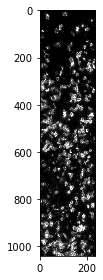

(7, 1040, 233, 1)
(1040, 233)


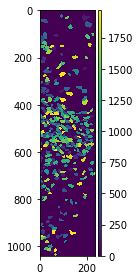

(7, 1040, 233, 1)


In [10]:
# read image files
imgfiles = glob.glob('images/test/*_img.png')
print(imgfiles)

# show one file
img=io.imread(imgfiles[0])
print(img.shape)
im=img[:,:]
io.imshow(im)
plt.show()

imgs = [io.imread(imgfile)[:,:] for imgfile in imgfiles]

X_train = tf.stack(imgs)
X_train = np.expand_dims(X_train, axis=-1)
print(X_train.shape)

# read mask files
maskfiles = glob.glob('images/test/*_masks.png')
img=io.imread(maskfiles[0])
print(img.shape)
im=img
io.imshow(im)
plt.show()

masks = [io.imread(imgfile) for imgfile in maskfiles]

y_train = tf.stack(masks)
y_train = np.expand_dims(y_train, axis=-1)
print(y_train.shape)

np.savez("K_training_data", X=X_train, y=y_train) # objects to save need to be key value pairs

test_size=.2
seed=0
train_dict, test_dict = get_data("K_training_data.npz", test_size=test_size, seed=seed)

In [ ]:
# Training model
# One-channel (CD3)
MODEL_PATH = ('https://deepcell-data.s3-us-west-1.amazonaws.com/saved-models/CytoplasmSegmentation-3.tar.gz')
MODEL_HASH = '6a244f561b4d37169cb1a58b6029910f'
archive_path = tf.keras.utils.get_file(
                'CytoplasmSegmentation.tgz', MODEL_PATH,
                file_hash=MODEL_HASH,
                extract=True, cache_subdir='models')
model_path = os.path.splitext(archive_path)[0]
new_model = tf.keras.models.load_model(model_path)
#new_model.save_weights('/home/shan/cyto_pretrained_weights.h5')

model_name = '20221009'
n_epoch = 100
optimizer = Adam(learning_rate=1e-4, clipnorm=0.001)
lr_sched = rate_scheduler(lr=1e-4, decay=0.99)
batch_size = 1 # 8
min_objects = 0  # throw out images with fewer than this many objects
seed=0
model_name

datagen = image_generators.CroppingDataGenerator(
    rotation_range=180,
    shear_range=0,
    zoom_range=(0.7, 1/0.7),
    horizontal_flip=True,
    vertical_flip=True,
    #crop_size=(256, 256)) # generate error
    crop_size=(512, 512))

datagen_val = image_generators.SemanticDataGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0)
    
train_data = datagen.flow(
    train_dict,
    seed=seed,
    transforms=['inner-distance','pixelwise'],
    transforms_kwargs={'pixelwise':{'dilation_radius': 1}, 
                      'inner-distance': {'erosion_width': 1, 'alpha': 'auto'}},
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    test_dict,
    seed=seed,
    transforms=['inner-distance', 'pixelwise'],
    transforms_kwargs={'pixelwise':{'dilation_radius': 1},
                      'inner-distance': {'erosion_width': 1, 'alpha': 'auto'}},
    min_objects=min_objects,
    batch_size=batch_size)

# Define loss (create a dictionary of losses for each semantic head)

def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * losses.weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss

loss = {}

# Give losses for all of the semantic heads
for layer in new_model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)

new_model.compile(loss=loss, optimizer=optimizer)

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 6a244f561b4d37169cb1a58b6029910f so we will re-download the data.
67444736/95263450 [====================>.........] - ETA: 10s

In [5]:
MODEL_DIR = os.path.join('models')
LOG_DIR = os.path.join('logs')

model_path = os.path.join(MODEL_DIR, '{}.h5'.format(model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(model_name))

#num_gpus = count_gpus()
#print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    tensorboard_log_dir=LOG_DIR,
    save_weights_only=True,
    #save_weights_only=num_gpus >= 2,
    #monitor='val_loss',
    monitor='loss', # training loss
    verbose=1)

start = default_timer()
loss_history = new_model.fit_generator(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    #validation_data=val_data,
    #validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)
training_time = default_timer() - start
print('Training time: ', training_time, 'seconds.')


/tmp/ipykernel_28164/1164638064.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  loss_history = new_model.fit_generator(
/app/software/scikit-image/0.19.1-foss-2021b/lib/python3.9/site-packages/skimage/morphology/misc.py:39: FutureWarning: `selem` is a deprecated argument name for `binary_dilation`. It will be removed in version 1.0.Please use `footprint` instead.
  return func(image, footprint=footprint, *args, **kwargs)
/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/100


2022-10-09 19:28:34.306999: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


5/5 [==============================] - ETA: 0s - loss: 0.3225 - semantic_0_loss: 0.0402 - semantic_1_loss: 0.2823
Epoch 00001: loss improved from inf to 0.32251, saving model to models/20221009.h5
5/5 [==============================] - 23s 502ms/step - loss: 0.3225 - semantic_0_loss: 0.0402 - semantic_1_loss: 0.2823 - lr: 1.0000e-04
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.2883 - semantic_0_loss: 0.0335 - semantic_1_loss: 0.2548
Epoch 00002: loss improved from 0.32251 to 0.28829, saving model to models/20221009.h5
5/5 [==============================] - 3s 618ms/step - loss: 0.2883 - semantic_0_loss: 0.0335 - semantic_1_loss: 0.2548 - lr: 9.9000e-05
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.2790 - semantic_0_loss: 0.0356 - semantic_1_loss: 0.2435
Epoch 00003: loss improved from 0.28829 to 0.27904, saving model to models/20221009.h5
5/5 [==============================] - 3s 562ms/step - loss: 0.2790 - semantic_0_loss: 0.0356 - semant

Epoch 26/100
5/5 [==============================] - ETA: 0s - loss: 0.2558 - semantic_0_loss: 0.0312 - semantic_1_loss: 0.2247
Epoch 00026: loss did not improve from 0.24980
5/5 [==============================] - 2s 422ms/step - loss: 0.2558 - semantic_0_loss: 0.0312 - semantic_1_loss: 0.2247 - lr: 7.7782e-05
Epoch 27/100
5/5 [==============================] - ETA: 0s - loss: 0.2492 - semantic_0_loss: 0.0251 - semantic_1_loss: 0.2241
Epoch 00027: loss improved from 0.24980 to 0.24923, saving model to models/20221009.h5
5/5 [==============================] - 3s 547ms/step - loss: 0.2492 - semantic_0_loss: 0.0251 - semantic_1_loss: 0.2241 - lr: 7.7004e-05
Epoch 28/100
5/5 [==============================] - ETA: 0s - loss: 0.2527 - semantic_0_loss: 0.0284 - semantic_1_loss: 0.2243
Epoch 00028: loss did not improve from 0.24923
5/5 [==============================] - 2s 498ms/step - loss: 0.2527 - semantic_0_loss: 0.0284 - semantic_1_loss: 0.2243 - lr: 7.6234e-05
Epoch 29/100
5/5 [=========

5/5 [==============================] - ETA: 0s - loss: 0.2520 - semantic_0_loss: 0.0286 - semantic_1_loss: 0.2234
Epoch 00078: loss did not improve from 0.24223
5/5 [==============================] - 2s 457ms/step - loss: 0.2520 - semantic_0_loss: 0.0286 - semantic_1_loss: 0.2234 - lr: 4.6122e-05
Epoch 79/100
5/5 [==============================] - ETA: 0s - loss: 0.2470 - semantic_0_loss: 0.0238 - semantic_1_loss: 0.2232
Epoch 00079: loss did not improve from 0.24223
5/5 [==============================] - 2s 449ms/step - loss: 0.2470 - semantic_0_loss: 0.0238 - semantic_1_loss: 0.2232 - lr: 4.5661e-05
Epoch 80/100
5/5 [==============================] - ETA: 0s - loss: 0.2502 - semantic_0_loss: 0.0268 - semantic_1_loss: 0.2234
Epoch 00080: loss did not improve from 0.24223
5/5 [==============================] - 3s 516ms/step - loss: 0.2502 - semantic_0_loss: 0.0268 - semantic_1_loss: 0.2234 - lr: 4.5204e-05
Epoch 81/100
5/5 [==============================] - ETA: 0s - loss: 0.2468 - sem

(1040, 233)


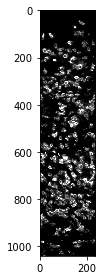

(1040, 233)


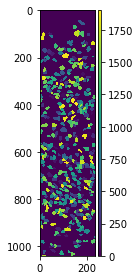

In [7]:
im0 = io.imread('../test/M872956_JML_Position8_CD3_test_img.png')
print(im0.shape)
im=im0
io.imshow(im)
plt.show()
im = np.expand_dims(im, axis=-1)
im = np.expand_dims(im, axis=0)

mask_true=io.imread("../test/M872956_JML_Position8_CD3_test_masks.png")
print(mask_true.shape)
io.imshow(mask_true)
plt.show()



0.0
0.0


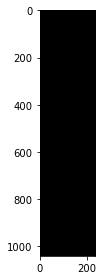

In [13]:
app = CytoplasmSegmentation(new_model)

x=im
y, tile_info = app._tile_input(x)
#print(x.shape)
#print(y.shape)
#print(tile_info)
pred = app.predict(y, image_mpp=1) 
prd = app._untile_output(pred, tile_info)
io.imshow(prd[0,:,:,0])
#plt.show()
print(syotil.csi(mask_true, prd[0,:,:,0])) # 0.21 without passing image_mpp. Setting image_mpp to 1 improves to 0.37

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 6a244f561b4d37169cb1a58b6029910f so we will re-download the data.
95272960/95263450 [==============================] - 31s 0us/step


0.05343511450381679


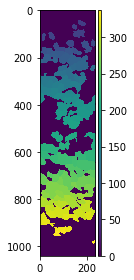

In [9]:
# Initiate CytoplasmSegmentation with pretrained model

MODEL_PATH = ('https://deepcell-data.s3-us-west-1.amazonaws.com/saved-models/CytoplasmSegmentation-3.tar.gz')
MODEL_HASH = '6a244f561b4d37169cb1a58b6029910f'
archive_path = tf.keras.utils.get_file(
                'CytoplasmSegmentation.tgz', MODEL_PATH,
                file_hash=MODEL_HASH,
                extract=True, cache_subdir='models')
model_path = os.path.splitext(archive_path)[0]
model = tf.keras.models.load_model(model_path)

app = CytoplasmSegmentation(model)
# same as app = CytoplasmSegmentation() because the model is the default one

x=im
y, tile_info = app._tile_input(x)
#print(x.shape)
#print(y.shape)
#print(tile_info)
pred = app.predict(y, image_mpp=1) 
prd = app._untile_output(pred, tile_info)
io.imshow(prd[0,:,:,0])
#plt.show()
print(syotil.csi(mask_true, prd[0,:,:,0])) # 0.21 without passing image_mpp. Setting image_mpp to 1 improves to 0.37